In [1]:
from utils.cmod5n import *
from utils.functions import *
from glob import glob
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy import stats


In [2]:
processed_data_path = Path("processed_data")
SAR_data_path = Path('SAR_data')

In [3]:
# df_wv1_unstable_gt15.to_parquet(processed_data_path / 'wv1_unstable_gt15_cmodv2.parquet')
# df_wv2_unstable_gt15.to_parquet(processed_data_path / 'wv2_unstable_gt15_cmodv2.parquet')

df_wv1_unstable_gt15 = pd.read_parquet(processed_data_path / 'wv1_unstable_gt15_cmodv3.parquet')
df_wv2_unstable_gt15 = pd.read_parquet(processed_data_path / 'wv2_unstable_gt15_cmodv3.parquet')

In [4]:
df_wv1_unstable_gt15.columns



Index(['value', 'wm_type', 'lonlat_center', 'tif_path', 'process_status',
       'class_1', 'prob_1', 'class_2', 'prob_2', 'class_3', 'prob_3',
       'all_prob', 'processing_time', 'filename', 'date_time', 'latitude',
       'longitude', 'L', 'wspd', 'wdir', 'sst', 'airt', 'p', 'rh', 'blh',
       'msdwswrf', 'msdwlwrf', 'renamed_filename', 'exists_ok',
       'path_to_sar_file', 'mean_sigma0', 'var_sigma0', 'skewness_sigma0',
       'spectral_stats', 'kurtosis_sigma0', 'mean_psd2d', 'var_psd2d',
       'skewness_psd2d', 'kurtosis_psd2d', 'mean_psd_band0', 'var_psd_band0',
       'skewness_psd_band0', 'kurtosis_psd_band0', 'mean_psd_band1',
       'var_psd_band1', 'skewness_psd_band1', 'kurtosis_psd_band1',
       'mean_psd_band2', 'var_psd_band2', 'skewness_psd_band2',
       'kurtosis_psd_band2', 'bandratio0_1', 'bandratio1_2',
       'wdir_from_north_deg', 'perturbed_wdir_deg', 'true_sigma0_median',
       'true_sigma0_row_var', 'true_sigma0_column_var', 'true_sigma0_skew',
       

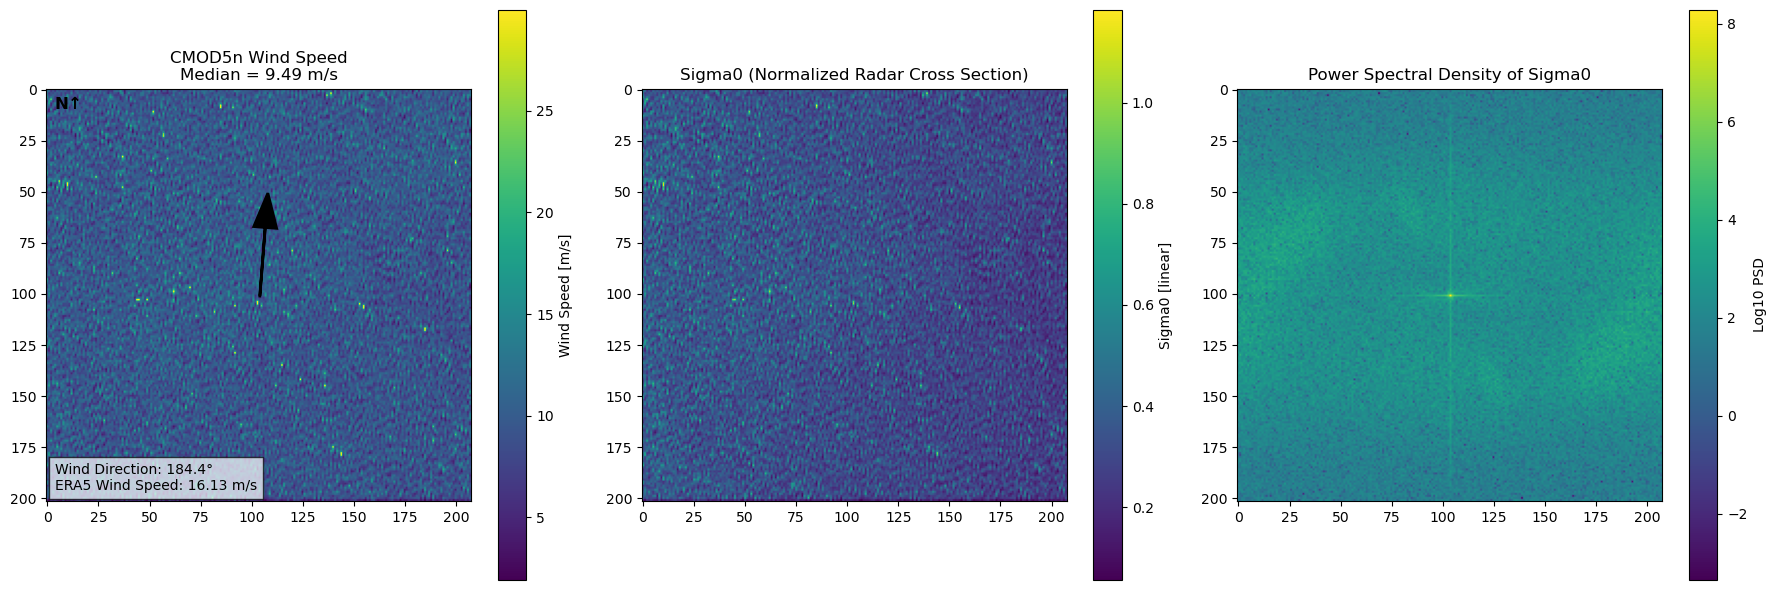

In [6]:
fig = plot_sar_wind(df_wv1_unstable_gt15, 50, SAR_data_path, cmod5n_inverse)
plt.show()

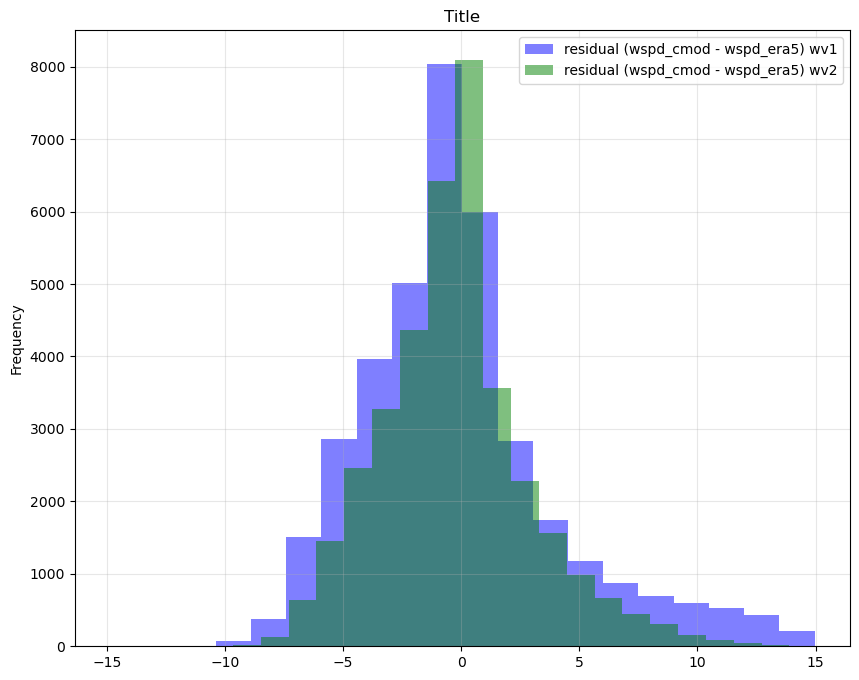

In [12]:
# Create a figure with two subplots stacked vertically
fig, ax1  = plt.subplots(1, 1, figsize=(10, 8), sharex=True)

# Plot first dataset (df_wv1_unstable_gt15) on top subplot
ax1.hist(df_wv1_unstable_gt15["residual"], bins=20, alpha=0.5, label="residual (wspd_cmod - wspd_era5) wv1", color="blue")
ax1.hist(df_wv2_unstable_gt15["residual"], bins=20, alpha=0.5, label="residual (wspd_cmod - wspd_era5) wv2",
          color="green")
ax1.set_title(f"Title")
ax1.set_ylabel("Frequency")
ax1.legend()
ax1.grid(alpha=0.3)

In [8]:
bias_wv1 = np.mean(df_wv1_unstable_gt15["residual"])
bias_wv2 = np.mean(df_wv2_unstable_gt15["residual"])

rmse_wv1 = np.sqrt(np.mean(df_wv1_unstable_gt15["residual"]**2))
rmse_wv2 = np.sqrt(np.mean(df_wv2_unstable_gt15["residual"]**2))

print(f"Bias WV1: {bias_wv1:.3f}, Bias WV2: {bias_wv2:.3f}")
print(f"RMSE WV1: {rmse_wv1:.3f}, RMSE WV2: {rmse_wv2:.3f}")


Bias WV1: -0.102, Bias WV2: -0.282
RMSE WV1: 4.189, RMSE WV2: 3.139


In [9]:
df_wv1_unstable_gt15["residual"].isna().sum(), df_wv2_unstable_gt15["residual"].isna().sum()

(4, 4)

In [10]:
# filter df_wv1_unstable_gt15 and df_wv2_unstable_gt15 to remove NaN values in residual
df_wv1_unstable_gt15 = df_wv1_unstable_gt15[~df_wv1_unstable_gt15["residual"].isna()]
df_wv2_unstable_gt15 = df_wv2_unstable_gt15[~df_wv2_unstable_gt15["residual"].isna()]

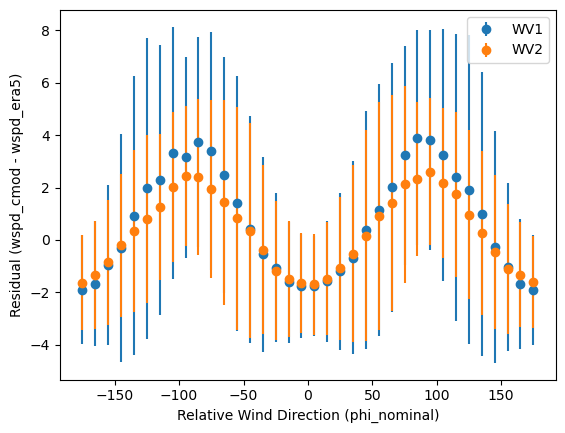

In [11]:
bin_edges = np.linspace(-180, 180, 37)  # Bin into 10° intervals
df_wv1_unstable_gt15['phi_bin'] = pd.cut(df_wv1_unstable_gt15['phi_nominal_median'], bins=bin_edges)
df_wv2_unstable_gt15['phi_bin'] = pd.cut(df_wv2_unstable_gt15['phi_nominal_median'], bins=bin_edges)

wv1_stats = df_wv1_unstable_gt15.groupby('phi_bin', observed=True)['residual'].agg(['mean', 'std'])
wv2_stats = df_wv2_unstable_gt15.groupby('phi_bin', observed=True)['residual'].agg(['mean', 'std'])

plt.errorbar(bin_edges[:-1] + 5, wv1_stats['mean'], yerr=wv1_stats['std'], label='WV1', fmt='o')
plt.errorbar(bin_edges[:-1] + 5, wv2_stats['mean'], yerr=wv2_stats['std'], label='WV2', fmt='o')
plt.xlabel("Relative Wind Direction (phi_nominal)")
plt.ylabel("Residual (wspd_cmod - wspd_era5)")
plt.legend()
